In [190]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet

import string

import re

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/atsukosakurai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/atsukosakurai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/atsukosakurai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [191]:
# import data
df = pd.read_csv('2020-12-31-DynamicallyGeneratedHateDataset-entries-v0.1.csv')
print(df.shape)
df.head()

(40623, 11)


,Unnamed: 0,id,text,label,type,model_wrong,db.model_preds,status,round,split,annotator
0,1,10000,It should be legal for a husband to rape his wife,hate,notgiven,True,0.97457,dynabench entry,1,train,gnzuctwed3
1,2,10001,dalits are lowlife scum,hate,notgiven,False,0.08233,dynabench entry,1,test,cagnluiznm
2,3,10002,dalits are lowlives,hate,notgiven,True,0.92319,dynabench entry,1,train,cagnluiznm
3,4,10003,It was a better world when women dare not ques...,hate,notgiven,True,0.99006,dynabench entry,1,test,gnzuctwed3
4,5,10004,I don't work this hard so that those immigrant...,hate,notgiven,True,0.98836,dynabench entry,1,train,cagnluiznm


In [192]:
df.isnull().sum()

Unnamed: 0            0
id                    0
text                  0
label                 0
type                  0
model_wrong       14526
db.model_preds    14526
status                0
round                 0
split                 0
annotator             0
dtype: int64

In [193]:
df.duplicated().sum()

0

In [194]:
df = df.dropna()
df.shape

(26097, 11)

In [195]:
df['label'].value_counts()

hate       15253
nothate    10844
Name: label, dtype: int64

In [196]:
# hate speech detected scenario 1:
# label == hate AND model_wrong == False
cond1a = df['label'] == 'hate'
cond1b = df['model_wrong'] == False
print(len(df[cond1a & cond1b]))
df[cond1a & cond1b].head(3)

5441


,Unnamed: 0,id,text,label,type,model_wrong,db.model_preds,status,round,split,annotator
1,2,10001,dalits are lowlife scum,hate,notgiven,False,0.08233,dynabench entry,1,test,cagnluiznm
9,10,10009,I don't work this hard so that all those pakis...,hate,notgiven,False,0.09288,dynabench entry,1,train,cagnluiznm
10,11,10010,I don't work this hard so that all those musli...,hate,notgiven,False,0.46144,dynabench entry,1,train,cagnluiznm


In [197]:
# hate speech detected scenario 2:
# label == nothate AND model_wrong == True
cond2a = df['label'] == 'nothate'
cond2b = df['model_wrong'] == True
print(len(df[cond2a & cond2b]))
df[cond2a & cond2b].head(3)

5624


,Unnamed: 0,id,text,label,type,model_wrong,db.model_preds,status,round,split,annotator
28,29,10029,I dont hatefucking Islam,nothate,none,True,0.05814,dynabench entry,1,train,vde7gn0nrl
29,30,10030,I dont hate fucking Muslims,nothate,none,True,0.00707,dynabench entry,1,train,vde7gn0nrl
31,32,10032,Government is incompetent,nothate,none,True,0.06605,dynabench entry,1,train,vde7gn0nrl


In [198]:
# print sample of first 10 texts labeled "correctly" as hate:

for t in df[cond1a & cond1b]['text'][:5]:
    print(t)
    print('\n')
    
for t in df[cond2a & cond2b]['text'][:5]:
    print(t)
    print('\n')

dalits are lowlife scum


I don't work this hard so that all those pakis can take the benefits


I don't work this hard so that all those muslims can take the benefits


Why is it that Africans smell weird? Do they not wash?


Arabs are dumb


I dont hatefucking Islam


I dont hate fucking Muslims


Government is incompetent


short women are fucking cute


disabled people are stupid




In [199]:
# add a new column to simplify dataset:
# new column = "hate_detected"
# will be true if:
# label = 'hate' AND model_wrong = false OR
# label = 'nothate' AND model_wrong = true

df['AL_detected'] = np.where((cond1a & cond1b)|(cond2a & cond2b), True, False)

In [200]:
df.head()

,Unnamed: 0,id,text,label,type,model_wrong,db.model_preds,status,round,split,annotator,AL_detected
0,1,10000,It should be legal for a husband to rape his wife,hate,notgiven,True,0.97457,dynabench entry,1,train,gnzuctwed3,False
1,2,10001,dalits are lowlife scum,hate,notgiven,False,0.08233,dynabench entry,1,test,cagnluiznm,True
2,3,10002,dalits are lowlives,hate,notgiven,True,0.92319,dynabench entry,1,train,cagnluiznm,False
3,4,10003,It was a better world when women dare not ques...,hate,notgiven,True,0.99006,dynabench entry,1,test,gnzuctwed3,False
4,5,10004,I don't work this hard so that those immigrant...,hate,notgiven,True,0.98836,dynabench entry,1,train,cagnluiznm,False


In [201]:
df['AL_detected'].value_counts()

False    15032
True     11065
Name: AL_detected, dtype: int64

<AxesSubplot:>

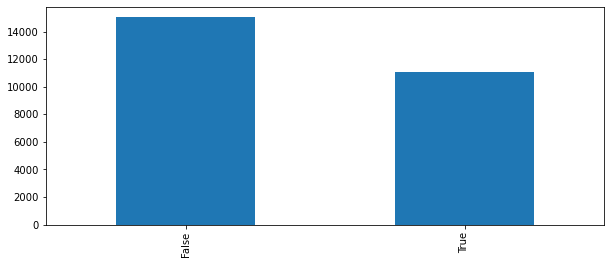

In [202]:
plt.figure(figsize=(10,4))
df.AL_detected.value_counts().plot(kind='bar')

In [203]:
# sanity check
len(df[cond2a & cond2b]) + len(df[cond1a & cond1b])

11065

In [204]:
# get rid of all columns other than text and hate_detected
df.columns
df = df.drop(columns=['Unnamed: 0', 'id', 'type', 'model_wrong',
       'db.model_preds', 'status', 'round', 'split', 'annotator','label'])

In [205]:
df.head()

,text,AL_detected
0,It should be legal for a husband to rape his wife,False
1,dalits are lowlife scum,True
2,dalits are lowlives,False
3,It was a better world when women dare not ques...,False
4,I don't work this hard so that those immigrant...,False


In [206]:
# lowercase all words:
def make_lower(a_string):
    return a_string.lower()

# test it
my_sent = 'ALL CAPS AND NOTHING ELSE HERE'
make_lower(my_sent)

'all caps and nothing else here'

In [207]:
# remove all punctuation

def remove_punc(a_string):
    a_string = re.sub(r'[^\w\s]', '', a_string)
    return a_string

my_sent = 'I_purposely! left @a lot+of=punctuations here!!%%%'
remove_punc(my_sent)

'I_purposely left a lotofpunctuations here'

In [208]:
# remove all stopwords

def remove_stopwords(a_string):
    words = word_tokenize(a_string)
    valid_words = []
    for word in words:
        if word not in stopwords:
            valid_words.append(word)
    a_string = ' '.join(valid_words)
    return a_string

my_sent = 'This is an apple, and I picked it from that tree on top of the hill next to the ocean'
remove_stopwords(my_sent)

'This apple , I picked tree top hill next ocean'

In [209]:
# stem words

def stem_words(a_string):
    porter = PorterStemmer()
    words = word_tokenize(a_string)
    valid_words = []
    
    for word in words:
        stemmed_word = porter.stem(word)
        valid_words.append(stemmed_word)
        
    a_string = ' '.join(valid_words)
    
    return a_string

my_sent = 'I am reading this book and then swimming to Mars.'
stem_words(my_sent)

'I am read thi book and then swim to mar .'

In [210]:
# look at "new" df
df.head()

,text,AL_detected
0,It should be legal for a husband to rape his wife,False
1,dalits are lowlife scum,True
2,dalits are lowlives,False
3,It was a better world when women dare not ques...,False
4,I don't work this hard so that those immigrant...,False


In [211]:
# lower case only, leave punc in, don't stem words

df['text_clean'] = df['text'].apply(make_lower)
print('Original:', df['text'][0])
print('Cleaned:', df['text_clean'][0])

Original: It should be legal for a husband to rape his wife
Cleaned: it should be legal for a husband to rape his wife


In [212]:
df.head()

,text,AL_detected,text_clean
0,It should be legal for a husband to rape his wife,False,it should be legal for a husband to rape his wife
1,dalits are lowlife scum,True,dalits are lowlife scum
2,dalits are lowlives,False,dalits are lowlives
3,It was a better world when women dare not ques...,False,it was a better world when women dare not ques...
4,I don't work this hard so that those immigrant...,False,i don't work this hard so that those immigrant...


In [213]:
# define variables:

X = df['text_clean'].values

y = df['AL_detected'].values

In [214]:
# now try using n_grams

vectorizer_ng = TfidfVectorizer(ngram_range=(1, 2))
X = vectorizer_ng.fit_transform(X)

In [215]:
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42)

model = svm.SVC()

model.fit(X_train, y_train)

SVC()

In [216]:
accuracy = model.score(X_test, y_test)
print('Accuracy', accuracy)

Accuracy 0.7379310344827587


In [217]:
y_pred = model.predict(X_test)

In [218]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.73      0.87      0.79      3794
        True       0.76      0.55      0.64      2731

    accuracy                           0.74      6525
   macro avg       0.74      0.71      0.72      6525
weighted avg       0.74      0.74      0.73      6525



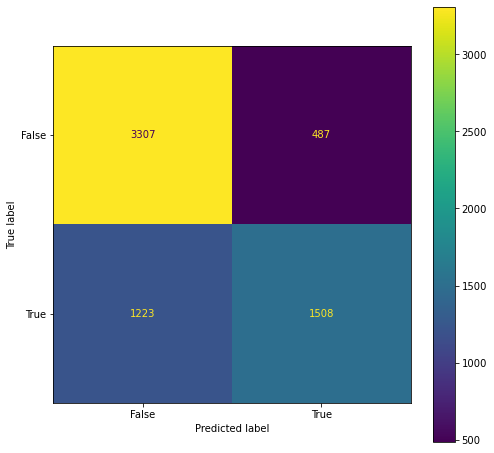

In [219]:
fig, ax = plt.subplots(figsize=(8,8))
metrics.plot_confusion_matrix(estimator=model, 
                              X=X_test, 
                              y_true=y_test, 
                              ax=ax)

In [220]:
# manual prediction

sample_text = "Truly weird Senator Rand Paul of Kentucky reminds me of a spoiled brat without a properly functioning brain. He was terrible at DEBATE!"
sample_text_clean = make_lower(sample_text)

print('Original:', sample_text, '\n')
print('Cleaned: ', sample_text_clean, '\n')

Original: Truly weird Senator Rand Paul of Kentucky reminds me of a spoiled brat without a properly functioning brain. He was terrible at DEBATE! 

Cleaned:  truly weird senator rand paul of kentucky reminds me of a spoiled brat without a properly functioning brain. he was terrible at debate! 



In [221]:
# 2. Transform your cleaned text using the `X = vectorizer.transform([your_text])`\

X_new = vectorizer_ng.transform([sample_text_clean])

# 3. Use the model to predict your new `X`. 

y_pred_new = model.predict(X_new)

# 4. Print the prediction
print('Predicted Category:', y_pred_new)

Predicted Category: [False]


In [223]:
df.head()

,text,AL_detected,text_clean
0,It should be legal for a husband to rape his wife,False,it should be legal for a husband to rape his wife
1,dalits are lowlife scum,True,dalits are lowlife scum
2,dalits are lowlives,False,dalits are lowlives
3,It was a better world when women dare not ques...,False,it was a better world when women dare not ques...
4,I don't work this hard so that those immigrant...,False,i don't work this hard so that those immigrant...


In [224]:
import pickle

# NAME YOUR MODEL 
filename = 'svm_model.pkl'

# EXPORT AND SAVE YOUR MODEL USING YOUR FILENAME
pickle.dump(model, open(filename, 'wb'))